In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

%matplotlib inline

# Generate Kuzushiji images

### Create z-vector to sample digit from latent space

First, we need to define the region of latent space in which we are sampling images for our digit. The construct_numvec function creates the z-vector that specifies this region for either the latent space for KMNIST or the latent space for K49. Additionally, it appends a one-hot encoding of the class label of the kuzushiji character we want to generate. For example, if we have a z-vector [0, 1, 1, 1, 0, 1, 0, 1, 0, 0] and we want to generate the third character from the KMNIST data set, the one-hot encoding of the third character would be [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], and that would be concatenated to the z-vector.

In [24]:
def construct_numvec(digit: int, latent_dim: int=10, classes: int=10, z: list=None) -> list:
    """
        digit: int -> the class of the kuzushiji character to be generated
        latent_dim: int -> the number of dimensions in the latent space: equal to the number of classes
        classes: int -> the number of class labels for a given model (10 for KMNIST, 49 for K49)
        z: list -> the z-vector indicating the position in latent space to sample an character
    """
    
    out = np.zeros((1, latent_dim + classes))
    out[:, digit + latent_dim] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

Next, we need to define a function that generates images for a specified digit. This function will receive arguments to define the number of rows and cols in the latent space we want sample from

In [26]:
def generate_images(digit: int=0, rows: int=10, cols: int=10, max_z: float=1.5, decoder: int=0, save_fig: bool=False) -> np.ndarray:
    """ Return an array
    
            digit: int -> the class of the kuzushiji character to be generated
            rows: int -> the width of the latent space
            cols: int -> the height of the latent space
            max_z: float ->
            decoder: int -> the generator to be used to create augmented data (0 for K49, 1 for KMNIST)
            save_fig: bool -> determines if an image of the augmented data should be created
    """
    
    images = []
    
    if decoder:
        decoder = keras.models.load_model("decoder-KMNIST")
        latent_dim = 10
        classes = 10
    else:
        decoder = keras.models.load_model("decoder-K49")
        latent_dim = 49
        classes = 49

    if save_fig:
        fig, axs = plt.subplots(rows, cols)
        fig.set_figwidth(28)
        fig.set_figheight(28)

    for i in range(0, rows):
        z1 = (((i / (rows-1)) * max_z)*2) - max_z
        for j in range(0, cols):
            z2 = (((j / (cols-1)) * max_z)*2) - max_z
            z_ = [z1, z2]
            vec = construct_numvec(digit, 10, 10, z_)
            decoded = decoder.predict(vec)
            images.append(decoded.reshape(28,28))
            if save_fig:
                axs[i, j].imshow(decoded.reshape(28,28), cmap=plt.cm.gray)
                axs[i, j].axis('off')
    
    if save_fig:
        fig.savefig("image_%d_%d_%d.png" % (digit, rows, cols))
        
    return np.array(images)

In [27]:
# Generate some example images of the first class for KMNIST
aug_data = generate_images(digit=0, rows=10, cols=10, max_z=1.5, decoder=1, save_fig=False)

In [5]:
aug_data.shape

(100, 28, 28)

### Generate images from latent space for KMNIST or K49

Let's generate some augmented data to train with. We'll start off with creating 100 sample images from each class of KMNIST. Feel free to change the number of images generated by altering the number of rows and columns. Additionally, feel free to change the model to K49 to find out how well it trains with the augmented data.

In [6]:
def generate_aug_kmnist():
    images = generate_images(digit=0, rows=10, cols=10, max_z=1.5, decoder=1)
    labels = []
    labels.append([0 for x in range(10) for y in range(10)])
    for digit in range(1,10):
        aug_data = generate_images(digit=digit, rows=10, cols=10, max_z=1.5, decoder=1)
        images = np.concatenate((images, aug_data), axis=0)
        labels.append([digit for x in range(10) for y in range(10)])
        
    return images, np.array(labels).flatten()
    
def generate_aug_k49():
    images = generate_images(digit=0, rows=10, cols=10, max_z=1.5, decoder=0)
    labels = []
    labels.append([digit for x in range(49) for y in range(49)])
    for digit in range(1,49):
        aug_data = generate_images(digit=digit, rows=10, cols=10, max_z=1.5, decoder=0)
        images = np.concatenate((images, aug_data), axis=0)
        labels.append([0 for x in range(49) for y in range(49)])
        
    return images, np.array(labels).flatten()

In [8]:
aug_kmnist_data, aug_kmnist_labels = generate_aug_kmnist()

### Define CNN model and set up training

Let's define the CNN model we'll use to evaluate the quality of the augmented data. The functions below define the CNN model, the training process, and evaluation process.

In [ ]:
# define cnn model
def define_model(kmnist=True):
    """
        kmnist: bool -> specifies whether the CNN model to be constructed should be for KMNIST(True) or K49(False)
    """
    model = keras.models.Sequential()
    
    if kmnist:
        model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.Dense(10, activation='softmax'))
        
    else:
        model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.MaxPooling2D((2, 2)))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
        model.add(keras.layers.Dense(49, activation='softmax'))
        
    # compile model
    opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, X_test, n_folds=1, kmnist=True):
    scores, histories, predictions = list(), list(), list()
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
    
    # If n_folds equals 1, do not perform cross-validation
    # Otherwise, implement cross-validation
    if n_folds > 1:
        # prepare cross validation
        kfold = KFold(n_folds, shuffle=True, random_state=1)
        i = 1
        for train_ix, test_ix in kfold.split(dataX):
            print("- - - - -\nFold %d\n- - - - -" % i)
            # define model
            model = define_model(kmnist)
            # select rows for train and test
            trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

            # fit model
            history = model.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY), callbacks=[callback], verbose=1)
            # evaluate model
            _, acc = model.evaluate(testX, testY, verbose=0)
            print('> %.3f\n' % (acc * 100.0))
            prediction = model.predict(X_test)

            # Save validation loss, accuracies, and predictions
            scores.append(acc)
            histories.append(history)
            predictions.append(prediction)

            i += 1

        return scores, histories, predictions
    
    
        # define model
        model = define_model(kmnist)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=128, validation_data=(testX, testY), callbacks=[callback], verbose=1)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f\n' % (acc * 100.0))
        prediction = model.predict(X_test)

        # Save validation loss, accuracies, and predictions
        scores.append(acc)
        histories.append(history)
        predictions.append(prediction)
    
    return scores, histories, predictions
    
    
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

def run_test_harness(trainX, trainY, testX, testY, n_folds=1, kmnist=True):
    # evaluate model
    scores, histories, predictions = evaluate_model(trainX, trainY, testX, n_folds=n_folds, kmnist=kmnist)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

### Load Kuzushiji data set and pre-process

Before we train, we need to load our data set that will be used to train the CNN model. For now, we'll start with using KMNIST. When we load the KMNIST data set, we will normalize the original and augmented data and then concatenate them together to form the new training set.

In [28]:
# scale pixels
def prep_pixels(train, *args):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = None
    if len(args) == 1:
        test_norm = args[0].astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    if len(args) == 1:
        test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# load train and test dataset
def load_dataset(kmnist=True):
    
    if kmnist:
        # Load the KMNIST data set
        training_data_files = "./dataset/kmnist-train-imgs.npz"
        testing_data_files = "./dataset/kmnist-test-imgs.npz"
        training_label_files = "./dataset/kmnist-train-labels.npz"
        testing_label_files = "./dataset/kmnist-test-labels.npz"
        
        (trainX, trainY) = np.load(training_data_files)["arr_0"], np.load(training_label_files)["arr_0"]
        (testX, testY) = np.load(testing_data_files)["arr_0"], np.load(testing_label_files)["arr_0"]

        # Reshape the images for training 
        trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
        testX = testX.reshape((testX.shape[0], 28, 28, 1))
        
        # Convert class labels into one-hot encoding vectors
        trainY, testY = keras.utils.to_categorical(trainY, num_classes=10), keras.utils.to_categorical(testY, num_classes=10)
        
        # prepare pixel data
        trainX, testX = prep_pixels(trainX, testX)
        
        # Concatenate original KMNIST data with augmented data
        trainX = np.concatenate((trainX, aug_kmnist_data), axis=0)
        trainY = np.concatenate((trainY, aug_kmnist_labels_1h), axis=0)

        return trainX, trainY, testX, testY
    
    # Load the K49 data set
    training_data_files = "./dataset/k49-train-imgs.npz"
    testing_data_files = "./dataset/k49-test-imgs.npz"
    training_label_files = "./dataset/k49-train-labels.npz"
    testing_label_files = "./dataset/k49-test-labels.npz"
    
    (trainX, trainY) = np.load(training_data_files)["arr_0"], np.load(training_label_files)["arr_0"]
    (testX, testY) = np.load(testing_data_files)["arr_0"], np.load(testing_label_files)["arr_0"]
    
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    trainY, testY = keras.utils.to_categorical(trainY, num_classes=49), keras.utils.to_categorical(testY, num_classes=49)
    
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    
    # Concatenate original K49 data with augmented data
    trainX = np.concatenate((trainX, aug_kmnist_data), axis=0)
    trainY = np.concatenate((trainY, aug_kmnist_labels_1h), axis=0)
    
    return trainX, trainY, testX, testY


In [10]:
aug_kmnist_data, _ = prep_pixels(aug_kmnist_data)
aug_kmnist_data = aug_kmnist_data.reshape((aug_kmnist_data.shape[0], 28, 28, 1))

In [11]:
unique = np.unique(aug_kmnist_labels)
aug_kmnist_labels_1h = keras.utils.to_categorical(aug_kmnist_labels, num_classes=len(unique))
aug_kmnist_labels_1h

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
# load dataset
trainX, trainY, testX, testY = load_dataset(kmnist=True)

### Run Demo

Now it's time to run! Run the function below and observe the progress of the CNN models as they train with the augmented data. If you want to train with the K49 data set, make sure to switch the kmnist argument from True to False, and remember to make changes to the code above as well to load the K49 data set.

- - - - -
Fold 1
- - - - -
Epoch 1/10
235/235 [==============================] - 15s 62ms/step - loss: 0.6368 - accuracy: 0.7982 - val_loss: 0.2657 - val_accuracy: 0.9204
Epoch 2/10
235/235 [==============================] - 14s 60ms/step - loss: 0.2126 - accuracy: 0.9365 - val_loss: 0.1905 - val_accuracy: 0.9407
Epoch 3/10
235/235 [==============================] - 15s 62ms/step - loss: 0.1440 - accuracy: 0.9551 - val_loss: 0.1475 - val_accuracy: 0.9546
Epoch 4/10
235/235 [==============================] - 15s 63ms/step - loss: 0.1032 - accuracy: 0.9696 - val_loss: 0.1474 - val_accuracy: 0.9545
Epoch 5/10
235/235 [==============================] - 15s 63ms/step - loss: 0.0811 - accuracy: 0.9756 - val_loss: 0.1278 - val_accuracy: 0.9607
Epoch 6/10
235/235 [==============================] - 15s 66ms/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 0.1475 - val_accuracy: 0.9579
Epoch 7/10
235/235 [==============================] - 15s 64ms/step - loss: 0.0496 - accuracy: 0.9853 - val_l

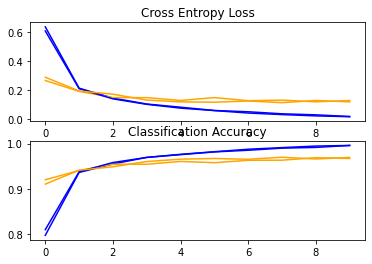

Accuracy: mean=96.833 std=0.117, n=2


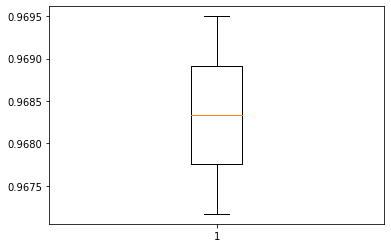

([0.9671666622161865, 0.9695000052452087],
 [array([[5.3523305e-05, 1.8305156e-01, 1.0850711e-01, ..., 1.4126401e-04,
          1.8605495e-04, 1.4916954e-02],
         [1.6821713e-07, 2.0846078e-04, 3.5683294e-09, ..., 7.0132232e-06,
          1.3834260e-09, 9.9977475e-01],
         [1.2343900e-11, 1.1290637e-12, 1.6536407e-07, ..., 4.0011917e-12,
          3.7642014e-09, 1.2191615e-12],
         ...,
         [6.7622139e-05, 6.6533263e-05, 4.6973680e-03, ..., 2.6276721e-06,
          4.5634774e-08, 9.9435848e-01],
         [6.2821168e-03, 1.2405485e-06, 1.7261277e-06, ..., 9.3315639e-06,
          1.8565377e-03, 2.9651010e-05],
         [1.3019263e-08, 5.8324408e-04, 5.6392598e-01, ..., 5.5278875e-02,
          1.1114673e-06, 3.8182892e-02]], dtype=float32),
  array([[9.2954224e-07, 6.7357269e-06, 9.7212797e-01, ..., 1.9290805e-04,
          5.9880695e-06, 1.1075543e-05],
         [1.2322989e-09, 5.9352267e-12, 5.9508249e-08, ..., 1.1296559e-07,
          3.3764623e-11, 9.9999893e-01]

In [21]:
run_test_harness(trainX, trainY, testX, testY, n_folds=1, kmnist=True)